In [66]:
%matplotlib inline


import os
import json
import pandas as pd
from glob import glob
from tqdm import tqdm
from pathlib import Path
# from joblib import Parallel, delayed
from dotenv import load_dotenv, find_dotenv

import matplotlib.pyplot as plt


load_dotenv(find_dotenv())

True

In [67]:
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

%load_ext autoreload

%autoreload 2
from visualization.visualize import *
from data.geo_utils import canonicalize_dataframe_geographies

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
API_KEY = os.environ.get('GMAPS_KEY', '')

In [5]:
def standardize_columns(df):
    df.columns = ['admin2', 'admin1', 'alpha-3']
    df.loc[:, 'alpha-3'] = df['alpha-3'].str.strip()
    return df

def add_country_names(df, iso):
    wanted = iso[['alpha-2', 'name']].rename(columns={'name': 'country'})
    df = df.join(wanted, on='alpha-3')
    return df.rename(columns=lambda c: c.replace('-', ''))

def add_provenance(df, name):
    df = df.reset_index().rename(columns={'index': 'idx'})
    df['provenance'] = name
    df['provenance'] = df.provenance + df.idx.astype(str)
    return df.drop('idx', axis=1).set_index('provenance')

def to_strings(df):
    series = df.apply(_join_row, axis=1)
    return series.drop_duplicates().values.tolist()

def get_search_string(row):
    print(row)
    return ', '.join([row['admin1'], row['admin2']])

In [6]:
ISO = Path('..')/'data'/'external'/'iso-codes.csv'
# this is tricksy because Namibia's alpha-2 is "NA" which gets read as NaN by default
iso = pd.read_csv(ISO, na_values=[], keep_default_na=False).set_index('alpha-3')

WHO = Path('..')/'data'/'interim'/'calc_cols_added.csv'
who = pd.read_csv(WHO, index_col=0).pipe(add_provenance, 'who')
vac = (who[['Admin1', 'Admin2', 'Iso Code']]
       .fillna('')
       .pipe(standardize_columns)
       .pipe(add_country_names, iso)
       .drop_duplicates())

NASA = Path('..')/'data'/'interim'/'external-processed/admin_population_nasa.csv'
nasa = pd.read_csv(NASA).pipe(add_provenance, 'nasa')
pop = (nasa[['NAME1', 'NAME2', 'ISOALPHA']]
       .fillna('')
       .pipe(standardize_columns)
       .pipe(add_country_names, iso)
       .drop_duplicates())

In [7]:
pop.size, vac.size

(211150, 114435)

In [8]:
who.head()

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,Coverage,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing
provenance,,,,,,,,,,,,,,,,,,
who0,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Band,1.0,1266.0,NaN,51.801245,655.803767,Aab Band,afghanistan,1,BCG,BCG,1st_birth
who1,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Kamari,1.0,4599.0,NaN,94.674670,4354.088093,Aab Kamari,afghanistan,1,BCG,BCG,1st_birth
who2,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aaqcha,1.0,5674.0,NaN,72.116489,4091.889607,Aaqcha,afghanistan,1,BCG,BCG,1st_birth
who3,AFG,Afghanistan,EMRO,2016,BCG,NaN,Acheen,1.0,4846.0,NaN,35.203626,1705.967701,Acheen,afghanistan,1,BCG,BCG,1st_birth
who4,AFG,Afghanistan,EMRO,2016,BCG,NaN,Adraskan,1.0,3557.0,NaN,81.468327,2897.828383,Adraskan,afghanistan,1,BCG,BCG,1st_birth


In [6]:
df = pd.concat([vac, pop]).sort_values(['country', 'admin1', 'admin2'])
df.head(20)

,admin2,admin1,alpha3,alpha2,country
provenance,,,,,
who0,,Aab Band,AFG,AF,Afghanistan
who1,,Aab Kamari,AFG,AF,Afghanistan
who2,,Aaqcha,AFG,AF,Afghanistan
nasa162,Ghazni,Ab Band,AFG,AF,Afghanistan
nasa83,Badghis,Ab Kamari,AFG,AF,Afghanistan
who3,,Acheen,AFG,AF,Afghanistan
nasa325,Nangarhar,Acheen,AFG,AF,Afghanistan
who4,,Adraskan,AFG,AF,Afghanistan
nasa204,Hirat,Adraskan,AFG,AF,Afghanistan


In [7]:
!http get https://maps.googleapis.com/maps/api/geocode/json key=="$API_KEY" address=="Hirat, Adraskan" components=="country:AF"

HTTP/1.1 200 OK
Access-Control-Allow-Origin: *
Alt-Svc: hq=":443"; ma=2592000; quic=51303431; quic=51303339; quic=51303338; quic=51303337; quic=51303335,quic=":443"; ma=2592000; v="41,39,38,37,35"
Cache-Control: public, max-age=86400
Content-Encoding: gzip
Content-Length: 428
Content-Type: application/json; charset=UTF-8
Date: Mon, 05 Mar 2018 23:38:53 GMT
Expires: Tue, 06 Mar 2018 23:38:53 GMT
Server: mafe
Vary: Accept-Language
X-Frame-Options: SAMEORIGIN
X-XSS-Protection: 1; mode=block

{
    "results": [
        {
            "address_components": [
                {
                    "long_name": "Adraskan", 
                    "short_name": "Adraskan", 
                    "types": [
                        "administrative_area_level_2", 
                        "political"
                    ]
                }, 
                {
                    "long_name": "Herat", 
                    "short_name": "Herat", 
                    "types": [
                        "admi

In [8]:
OUTPUT_DIR = Path('..')/'data'/'geocode'
#geocoder = GoogleV3(api_key=API_KEY)

def _geocode(search_string, alpha2, filename):
    !http get https://maps.googleapis.com/maps/api/geocode/json key=="$API_KEY" address=="$search_string" components=="country:$alpha2" > $filename

def get_filename(index):
    return OUTPUT_DIR/f"{index}.json"

def geocode_if_not_already_here(row):
    index, admin2, admin1, _, alpha2, _ = row
    filename = get_filename(index)
    if os.path.exists(filename):
        return False
    search_string = f"{admin2}, {admin1}" if admin2 else admin1
    _geocode(search_string, alpha2, filename)
    return True

In [9]:
rows = list(df.itertuples(name=None))
r = Parallel(n_jobs=26, verbose=5)(delayed(geocode_if_not_already_here)(row) for row in rows)

[Parallel(n_jobs=26)]: Done  20 tasks      | elapsed:    0.0s


/bin/sh: 1: Syntax error: EOF in backquote substitution
/bin/sh: 1: Syntax error: EOF in backquote substitution


[Parallel(n_jobs=26)]: Done 5496 tasks      | elapsed:    0.4s


/bin/sh: 1: Syntax error: EOF in backquote substitution
/bin/sh: 1: Syntax error: EOF in backquote substitution
/bin/sh: 1: Syntax error: Unterminated quoted string


[Parallel(n_jobs=26)]: Done 65117 out of 65117 | elapsed:    1.2s finished


In [13]:
def read_geocoded_results():
    files = glob('../data/geocode/*.json')
    canonicals = []
    for filepath in files:
        _, filename = os.path.split(filepath)
        index = filename.split('.')[0]
        with open(filepath, 'r') as f:
            try:
                payload = json.load(f)
            except json.JSONDecodeError:
                print('problem:', index)
        payload.update({'provenance': index})
        canonicals.append(payload)
    return canonicals

def extract_canonical_location_info(item):
    return {'provenance': item['provenance'],
            'place_id': item['results'][0]['place_id'] if item['results'] else None}

def canonical_df_from_geocoded_results(canonicals):
    generator = (extract_canonical_location_info(index) for index in canonicals)
    return pd.DataFrame.from_records(generator).set_index('provenance')

In [14]:
locaiton_df = canonical_df_from_geocoded_results(canonicals)

In [10]:
canonicals = read_geocoded_results()
canonicals[0]

problem: nasa12615
problem: nasa12361
problem: nasa12805
problem: nasa12872
problem: nasa12424
problem: nasa12077
problem: nasa12533
problem: nasa12315
problem: nasa11955
problem: nasa12565


{'provenance': 'nasa32369',
 'results': [{'address_components': [{'long_name': 'Chagang',
     'short_name': 'Chagang',
     'types': ['administrative_area_level_1', 'political']},
    {'long_name': 'North Korea',
     'short_name': 'KP',
     'types': ['country', 'political']}],
   'formatted_address': 'Chagang, North Korea',
   'geometry': {'bounds': {'northeast': {'lat': 41.80851699999999,
      'lng': 127.495489},
     'southwest': {'lat': 39.991374, 'lng': 125.4156571}},
    'location': {'lat': 40.7202809, 'lng': 126.5621137},
    'location_type': 'APPROXIMATE',
    'viewport': {'northeast': {'lat': 41.80851699999999, 'lng': 127.495489},
     'southwest': {'lat': 39.991374, 'lng': 125.4156571}}},
   'partial_match': True,
   'place_id': 'ChIJO9FvgPpMLV4R8LZwi9Ic_YA',
   'types': ['administrative_area_level_1', 'political']}],
 'status': 'OK'}

In [27]:
who.join(locaiton_df, how='left')

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,...,available_admin,normalized_country,indicator,group,vaccine,timing,place_id,who,nasa,row
provenance,,,,,,,,,,,,,,,,,,,,,
who0,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Band,1.0,1266.0,NaN,...,Aab Band,afghanistan,1,BCG,BCG,1st_birth,ChIJ3zPu6yKg1TgRt22VHZjzwm4,True,False,0
who1,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Kamari,1.0,4599.0,NaN,...,Aab Kamari,afghanistan,1,BCG,BCG,1st_birth,ChIJC6gloCKLOz8R-PEKVe9Z-Os,True,False,1
who10,AFG,Afghanistan,EMRO,2016,BCG,NaN,AliSheng,1.0,3857.0,NaN,...,AliSheng,afghanistan,1,BCG,BCG,1st_birth,ChIJuVBmFZqN0DgRSuFA5qRbw3o,True,False,10
who100,AFG,Afghanistan,EMRO,2016,BCG,NaN,Fayzabad,1.0,12784.0,NaN,...,Fayzabad,afghanistan,1,BCG,BCG,1st_birth,NaN,NaN,NaN,NaN
who1000,AFG,Afghanistan,EMRO,2016,DTP3,NaN,Shawak,2.0,627.0,NaN,...,Shawak,afghanistan,1,DTP,DTP3,4th_14wks_6mos,NaN,NaN,NaN,NaN
who10000,AGO,Angola,AFRO,2016,TT2plus,UIGE,Bungo,3.0,1456.0,NaN,...,UIGE - Bungo,angola,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
who100000,MOZ,Mozambique,AFRO,2016,DTP1,Cabo Delgado,NANGADE,2.0,2457.0,NaN,...,Cabo Delgado - NANGADE,mozambique,1,DTP,DTP1,2nd_6wks_2mos,NaN,NaN,NaN,NaN
who100001,MOZ,Mozambique,AFRO,2016,DTP1,Cabo Delgado,PALMA,2.0,1576.0,NaN,...,Cabo Delgado - PALMA,mozambique,1,DTP,DTP1,2nd_6wks_2mos,NaN,NaN,NaN,NaN
who100002,MOZ,Mozambique,AFRO,2016,DTP1,Cabo Delgado,QUISSANGA,2.0,1567.0,NaN,...,Cabo Delgado - QUISSANGA,mozambique,1,DTP,DTP1,2nd_6wks_2mos,NaN,NaN,NaN,NaN


In [30]:
wb = pd.read_csv(Path("../data/interim/external-processed/country_world_bank_indicators.csv"), index_col=0)

In [47]:
nasa.head()

,ISOALPHA,NAME1,NAME2,UN_2015_E,crude_birth_rate_2016,infant_mortality_rate_2016,est_denom_1,est_denom_2
provenance,,,,,,,,
nasa0,ABW,Noord/ Tanki Leendert,Alto Vista,5503.0,10.963,NaN,60.329389,NaN
nasa1,ABW,Noord/ Tanki Leendert,Moko/Tanki Flip,4071.0,10.963,NaN,44.630373,NaN
nasa2,ABW,Noord/ Tanki Leendert,Noord Other,0.0,10.963,NaN,0.000000,NaN
nasa3,ABW,Noord/ Tanki Leendert,Palm Beach/Malmok,5499.0,10.963,NaN,60.285537,NaN
nasa4,ABW,Noord/ Tanki Leendert,Tanki Leendert,3958.0,10.963,NaN,43.391554,NaN


In [38]:
nasa = nasa.merge(wb[['crude_birth_rate_2016', 'infant_mortality_rate_2016']], right_index=True, left_on='ISOALPHA')

nasa['est_denom_1'] = nasa.UN_2015_E * nasa.crude_birth_rate_2016 / 1000
nasa['est_denom_2'] = nasa.est_denom_1 * (1000 - nasa.infant_mortality_rate_2016) / 1000

In [57]:
nasa_places_and_estimates = (nasa.join(locaiton_df)
                                 .groupby('place_id')[['est_denom_1', 'est_denom_2', 'ISOALPHA']]
                                 .agg({'est_denom1': np.sum, 'est_denom_2': np.sum, 'ISOALPHA': 'first'}))

nasa_places_and_estimates = nasa_places_and_estimates.loc[:, 'ISOALPHA']

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [58]:
who_places_and_estimates = who.join(locaiton_df).groupby(['place_id', 'DenomType']).Denominator.sum().unstack()
who_places_and_estimates.head(2)

DenomType,1.0,2.0,5.0
place_id,,,
ChIJ--2uE4OoPkARWEh2fILMlzU,1868.0,NaN,NaN
ChIJ--A3JakhkZQRz_w9lSHGwdA,NaN,34.0,NaN


In [68]:
code_to_name = (who[['Iso Code', 'Country Name']].drop_duplicates()
                                                    .set_index('Iso Code')
                                                    .to_dict()['Country Name'])
code_to_name

{'AFG': 'Afghanistan',
 'AGO': 'Angola',
 'ALB': 'Albania',
 'ARG': 'Argentina',
 'ARM': 'Armenia',
 'AZE': 'Azerbaijan',
 'BDI': 'Burundi',
 'BEL': 'Belgium',
 'BEN': 'Benin',
 'BFA': 'Burkina Faso',
 'BGD': 'Bangladesh',
 'BGR': 'Bulgaria',
 'BHR': 'Bahrain',
 'BHS': 'Bahamas',
 'BIH': 'Bosnia & Herzegovina',
 'BLR': 'Belarus',
 'BLZ': 'Belize',
 'BOL': 'Bolivia',
 'BRA': 'Brazil',
 'BRB': 'Barbados',
 'BRN': 'Brunei',
 'BTN': 'Bhutan',
 'BWA': 'Botswana',
 'CAF': 'CAR',
 'CHL': 'Chile',
 'CIV': "Côte d'Ivoire",
 'CMR': 'Cameroon',
 'COD': 'DRCongo',
 'COG': 'Congo',
 'COL': 'Colombia',
 'COM': 'Comoros',
 'CPV': 'Cabo Verde',
 'CRI': 'Costa Rica',
 'CUB': 'Cuba',
 'CZE': 'Czechia',
 'DEU': 'Germany',
 'DMA': 'Dominica',
 'DNK': 'Denmark',
 'DOM': 'Dominican Republic',
 'DZA': 'Algeria',
 'ECU': 'Ecuador',
 'ERI': 'Eritrea',
 'ESP': 'Spain',
 'EST': 'Estonia',
 'ETH': 'Ethiopia',
 'FRA': 'France',
 'GAB': 'Gabon',
 'GBR': 'UK',
 'GEO': 'Georgia',
 'GHA': 'Ghana',
 'GIN': 'Guinea',
 '

In [75]:
code_to_name

{'AFG': 'Afghanistan',
 'AGO': 'Angola',
 'ALB': 'Albania',
 'ARG': 'Argentina',
 'ARM': 'Armenia',
 'AZE': 'Azerbaijan',
 'BDI': 'Burundi',
 'BEL': 'Belgium',
 'BEN': 'Benin',
 'BFA': 'Burkina Faso',
 'BGD': 'Bangladesh',
 'BGR': 'Bulgaria',
 'BHR': 'Bahrain',
 'BHS': 'Bahamas',
 'BIH': 'Bosnia & Herzegovina',
 'BLR': 'Belarus',
 'BLZ': 'Belize',
 'BOL': 'Bolivia',
 'BRA': 'Brazil',
 'BRB': 'Barbados',
 'BRN': 'Brunei',
 'BTN': 'Bhutan',
 'BWA': 'Botswana',
 'CAF': 'CAR',
 'CHL': 'Chile',
 'CIV': "Côte d'Ivoire",
 'CMR': 'Cameroon',
 'COD': 'DRCongo',
 'COG': 'Congo',
 'COL': 'Colombia',
 'COM': 'Comoros',
 'CPV': 'Cabo Verde',
 'CRI': 'Costa Rica',
 'CUB': 'Cuba',
 'CZE': 'Czechia',
 'DEU': 'Germany',
 'DMA': 'Dominica',
 'DNK': 'Denmark',
 'DOM': 'Dominican Republic',
 'DZA': 'Algeria',
 'ECU': 'Ecuador',
 'ERI': 'Eritrea',
 'ESP': 'Spain',
 'EST': 'Estonia',
 'ETH': 'Ethiopia',
 'FRA': 'France',
 'GAB': 'Gabon',
 'GBR': 'UK',
 'GEO': 'Georgia',
 'GHA': 'Ghana',
 'GIN': 'Guinea',
 '

In [77]:
diffs = (nasa_places_and_estimates.join(who_places_and_estimates, how='inner')
                                    .drop_duplicates()
                                    .assign(pct_diff1=lambda x: np.abs(x[1.0] - x.est_denom_1) / x.est_denom_1)
                                    .assign(pct_diff2=lambda x: np.abs(x[2.0] - x.est_denom_2) / x.est_denom_2)
                                    .assign(pct_diff=lambda x: np.where(pd.notnull(x.pct_diff1), x.pct_diff1, x.pct_diff2)))

diffs[diffs.ISOALPHA == 'RUS']

,est_denom_1,est_denom_2,ISOALPHA,1.0,2.0,5.0,pct_diff1,pct_diff2,pct_diff
place_id,,,,,,,,,
ChIJAS4yugIKt0YRizHZ99vDWRY,5157.4341,5123.395035,RUS,12623.0,NaN,NaN,1.447535,NaN,1.447535
ChIJDU8FOJPwMUER22dHyN39iUM,858.1293,852.465647,RUS,7287.0,NaN,NaN,7.491727,NaN,7.491727
ChIJHyMdKZGKqFwRLuE1LERdadI,12737.4765,12653.409155,RUS,33963.0,NaN,NaN,1.666384,NaN,1.666384
ChIJI_OrHRUvSEERzelNFHeHaD0,6799.1462,6754.271835,RUS,10826.0,NaN,NaN,0.592259,NaN,0.592259
ChIJO4mGd7lC8EARgJXxg6WjAgE,1706.6161,1695.352434,RUS,65563.0,NaN,NaN,37.416959,NaN,37.416959
ChIJXyfDUqZgskYRJA-YkhpiTE8,7613.6648,7563.414612,RUS,13990.0,NaN,NaN,0.837486,NaN,0.837486
ChIJ_0EiPofU50IR1TtsjXACf-4,329.5341,327.359175,RUS,26405.0,NaN,NaN,79.128278,NaN,79.128278
ChIJc7c_RiwJNEERSxxmDujG1aA,6436.8675,6394.384174,RUS,12558.0,NaN,NaN,0.950949,NaN,0.950949
ChIJc_dpU4GNHUMRPFMGiXZtmN8,1546.5506,1536.343366,RUS,33096.0,NaN,NaN,20.399882,NaN,20.399882


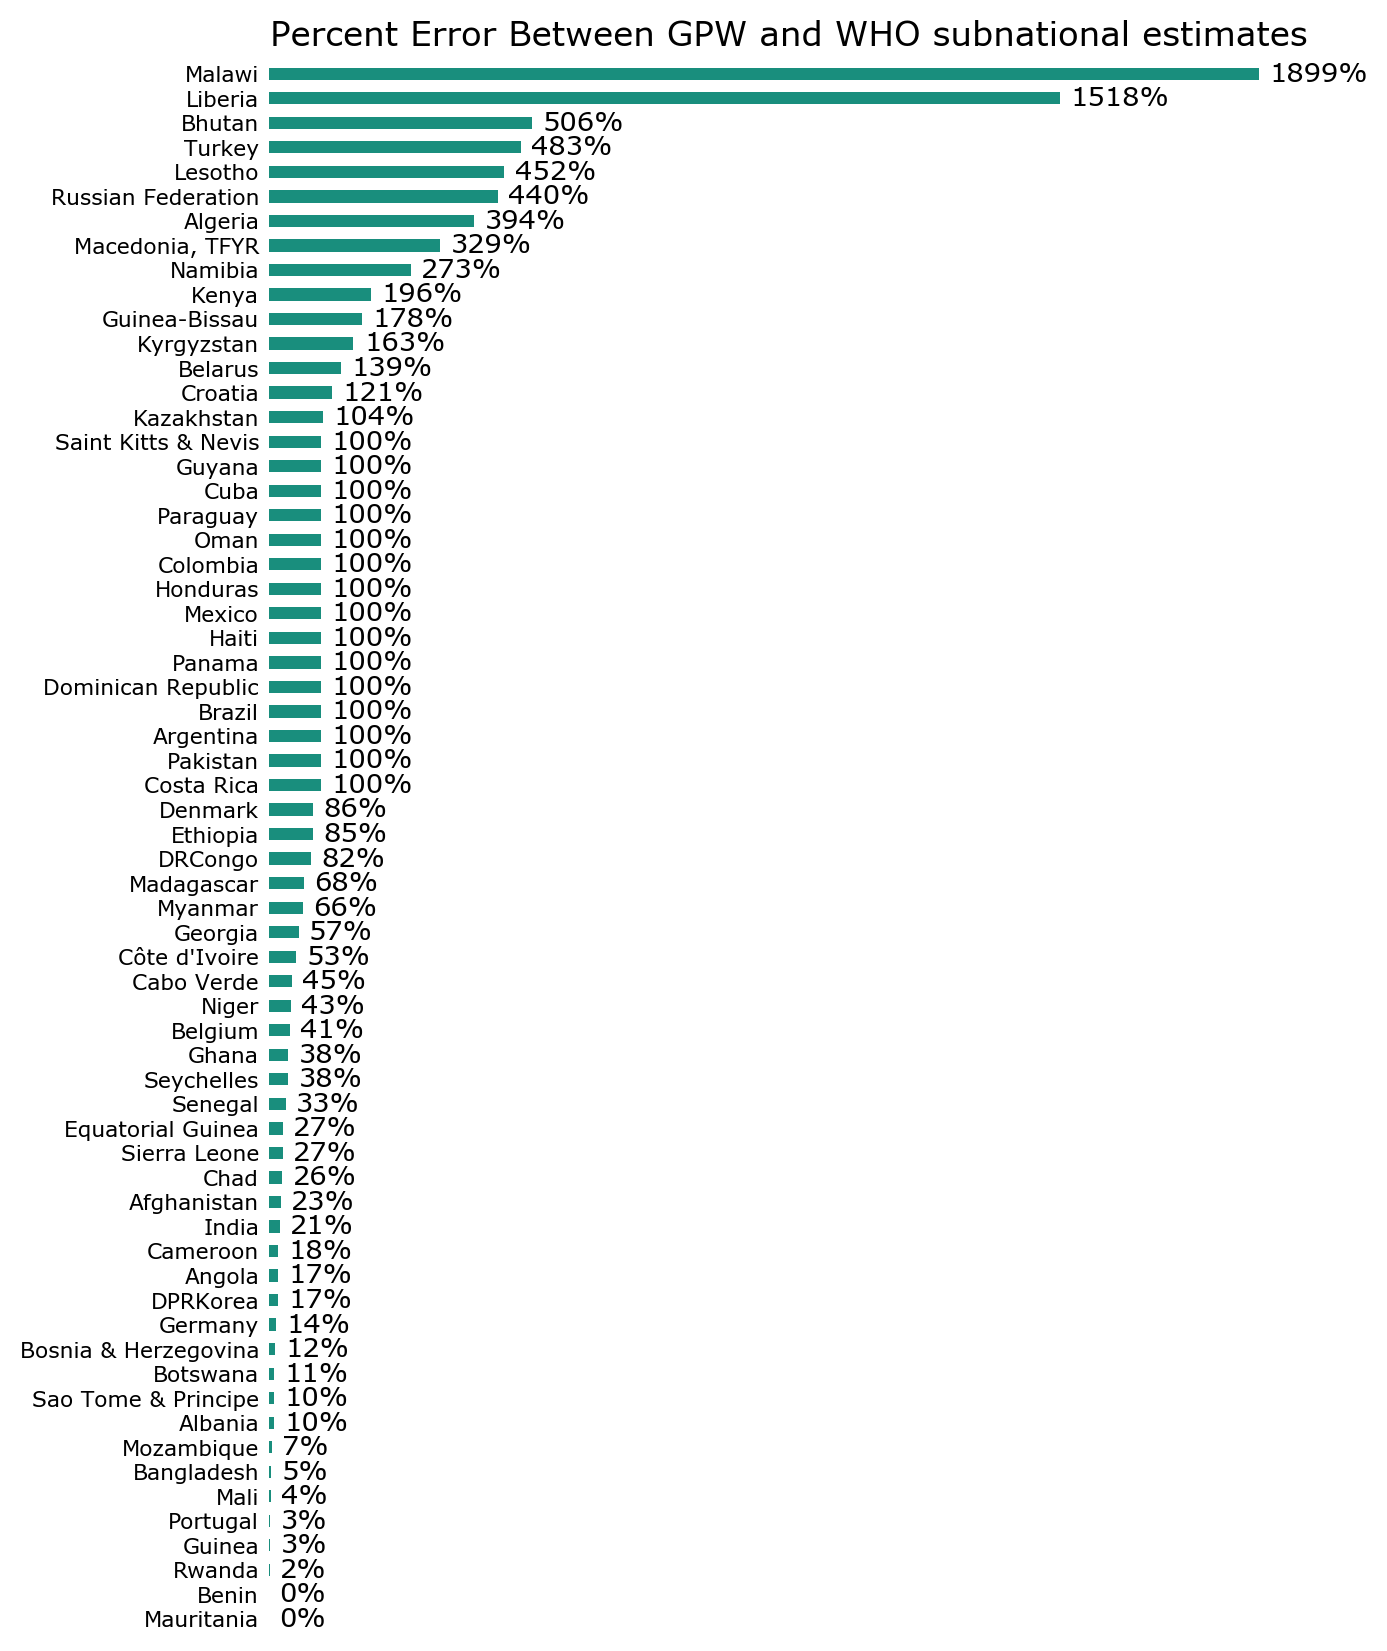

In [89]:
to_plot = (nasa_places_and_estimates.join(who_places_and_estimates, how='inner')
                                    .groupby('ISOALPHA')
                                    .sum()
                                    .assign(pct_diff1=lambda x: np.abs(x[1.0] - x.est_denom_1) / x.est_denom_1)
                                    .assign(pct_diff2=lambda x: np.abs(x[2.0] - x.est_denom_2) / x.est_denom_2)
                                    .assign(pct_diff=lambda x: np.where(pd.notnull(x.pct_diff1), x.pct_diff1, x.pct_diff2)))

to_plot = to_plot.pct_diff.sort_values(ascending=False)

to_plot.rename(index=code_to_name, inplace=True)

PLOT_LIM = 64
FS=10

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.head(PLOT_LIM).sort_values(),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['green']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Percent Error Between GPW and WHO subnational estimates'.format(PLOT_LIM))

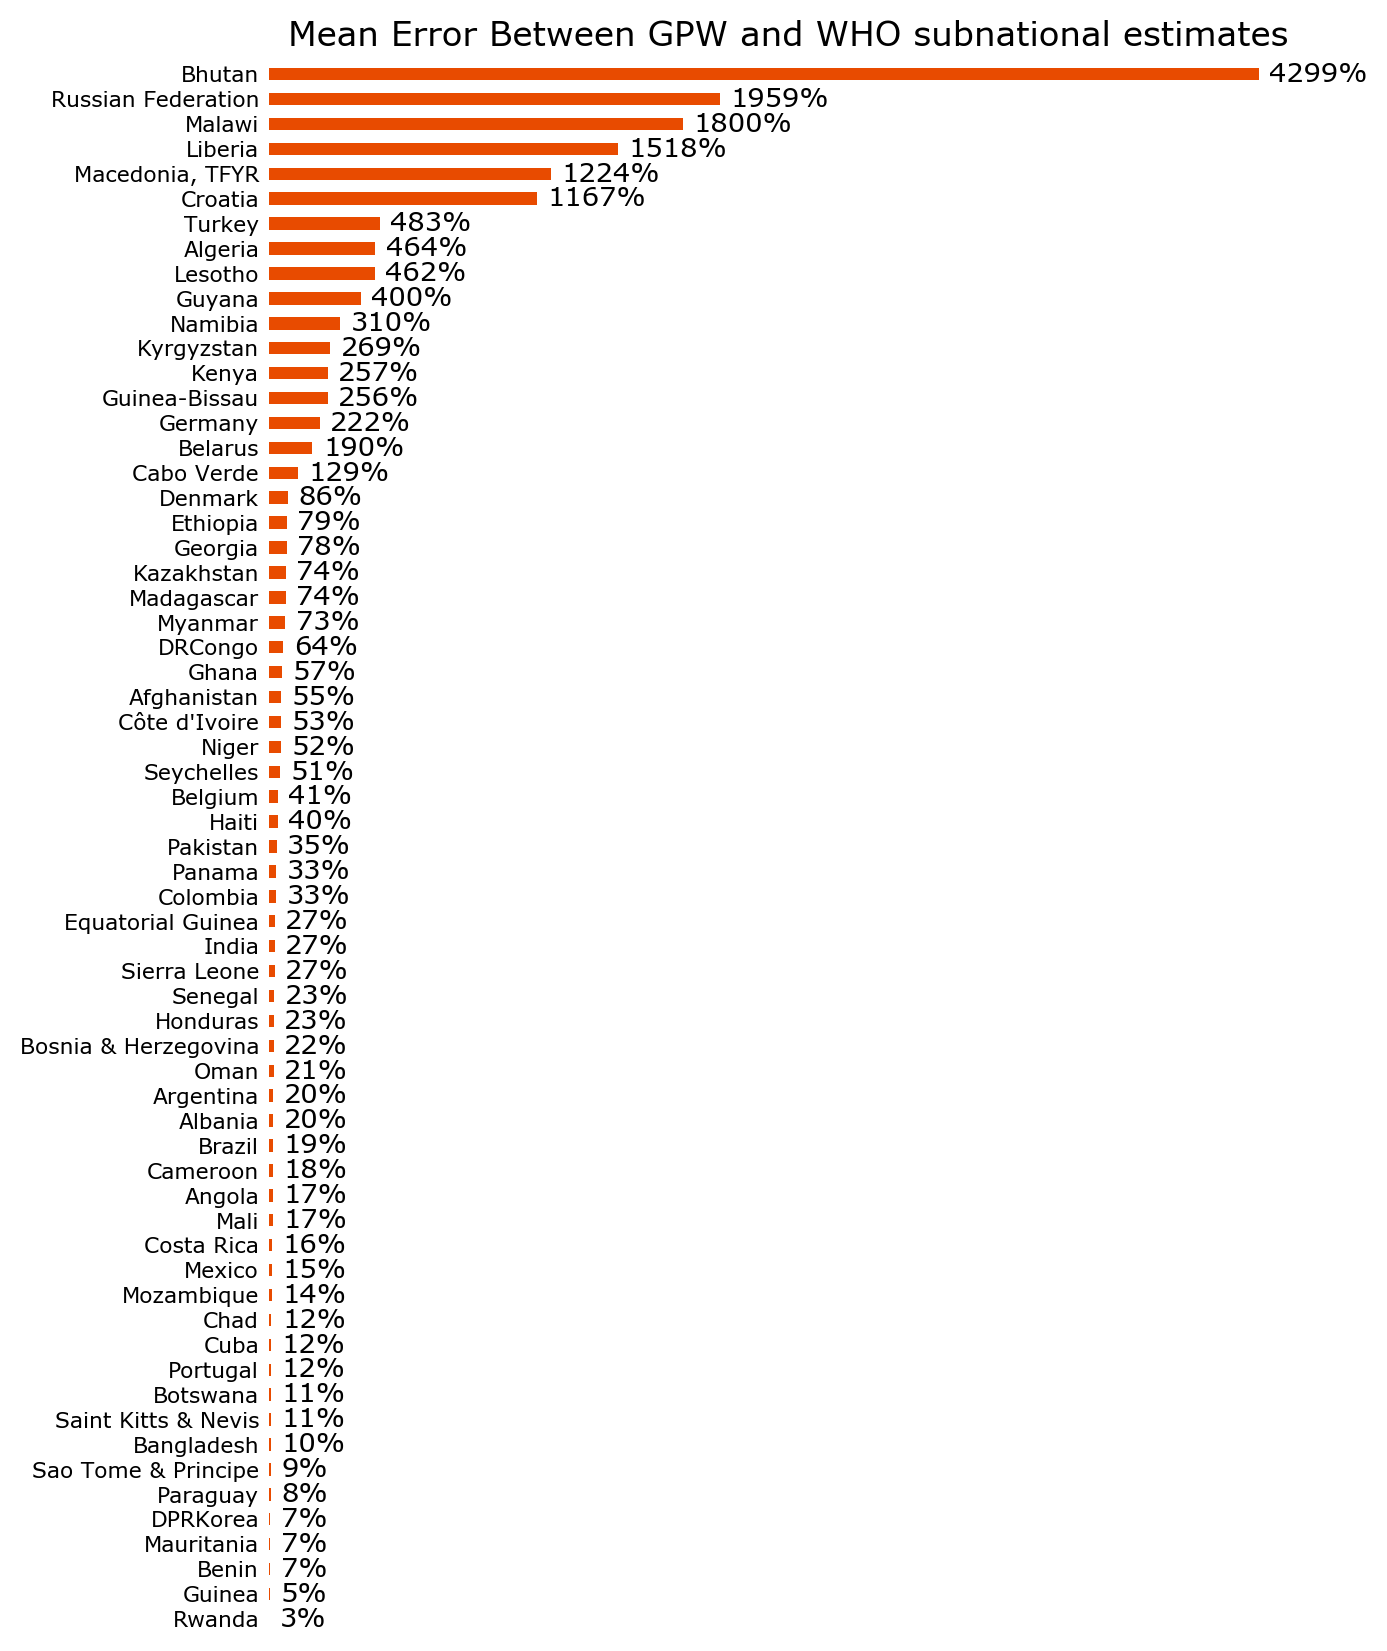

In [104]:
to_plot = (nasa_places_and_estimates.join(who_places_and_estimates, how='inner')
                                    .assign(pct_diff1=lambda x: np.abs(x[1.0] - x.est_denom_1) / x.est_denom_1)
                                    .assign(pct_diff2=lambda x: np.abs(x[2.0] - x.est_denom_2) / x.est_denom_2)
                                    .assign(pct_diff=lambda x: np.where(pd.notnull(x.pct_diff1), x.pct_diff1, x.pct_diff2))
                                    .assign(diff1=lambda x: np.abs(x[1.0] - x.est_denom_1))
                                    .assign(diff2=lambda x: np.abs(x[2.0] - x.est_denom_2))
                                    .assign(diff=lambda x: np.where(pd.notnull(x.diff1), x.diff1, x.diff2))
                                    .replace({np.inf: np.nan})
                                    .dropna(subset=['pct_diff']) 
                                    .groupby('ISOALPHA')
                                    .pct_diff
                                    .mean()
                                    .sort_values(ascending=False))

to_plot.rename(index=code_to_name, inplace=True)

PLOT_LIM = 64
FS=10

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.head(PLOT_LIM).sort_values(),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['orange']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Mean Error Between GPW and WHO subnational estimates'.format(PLOT_LIM))

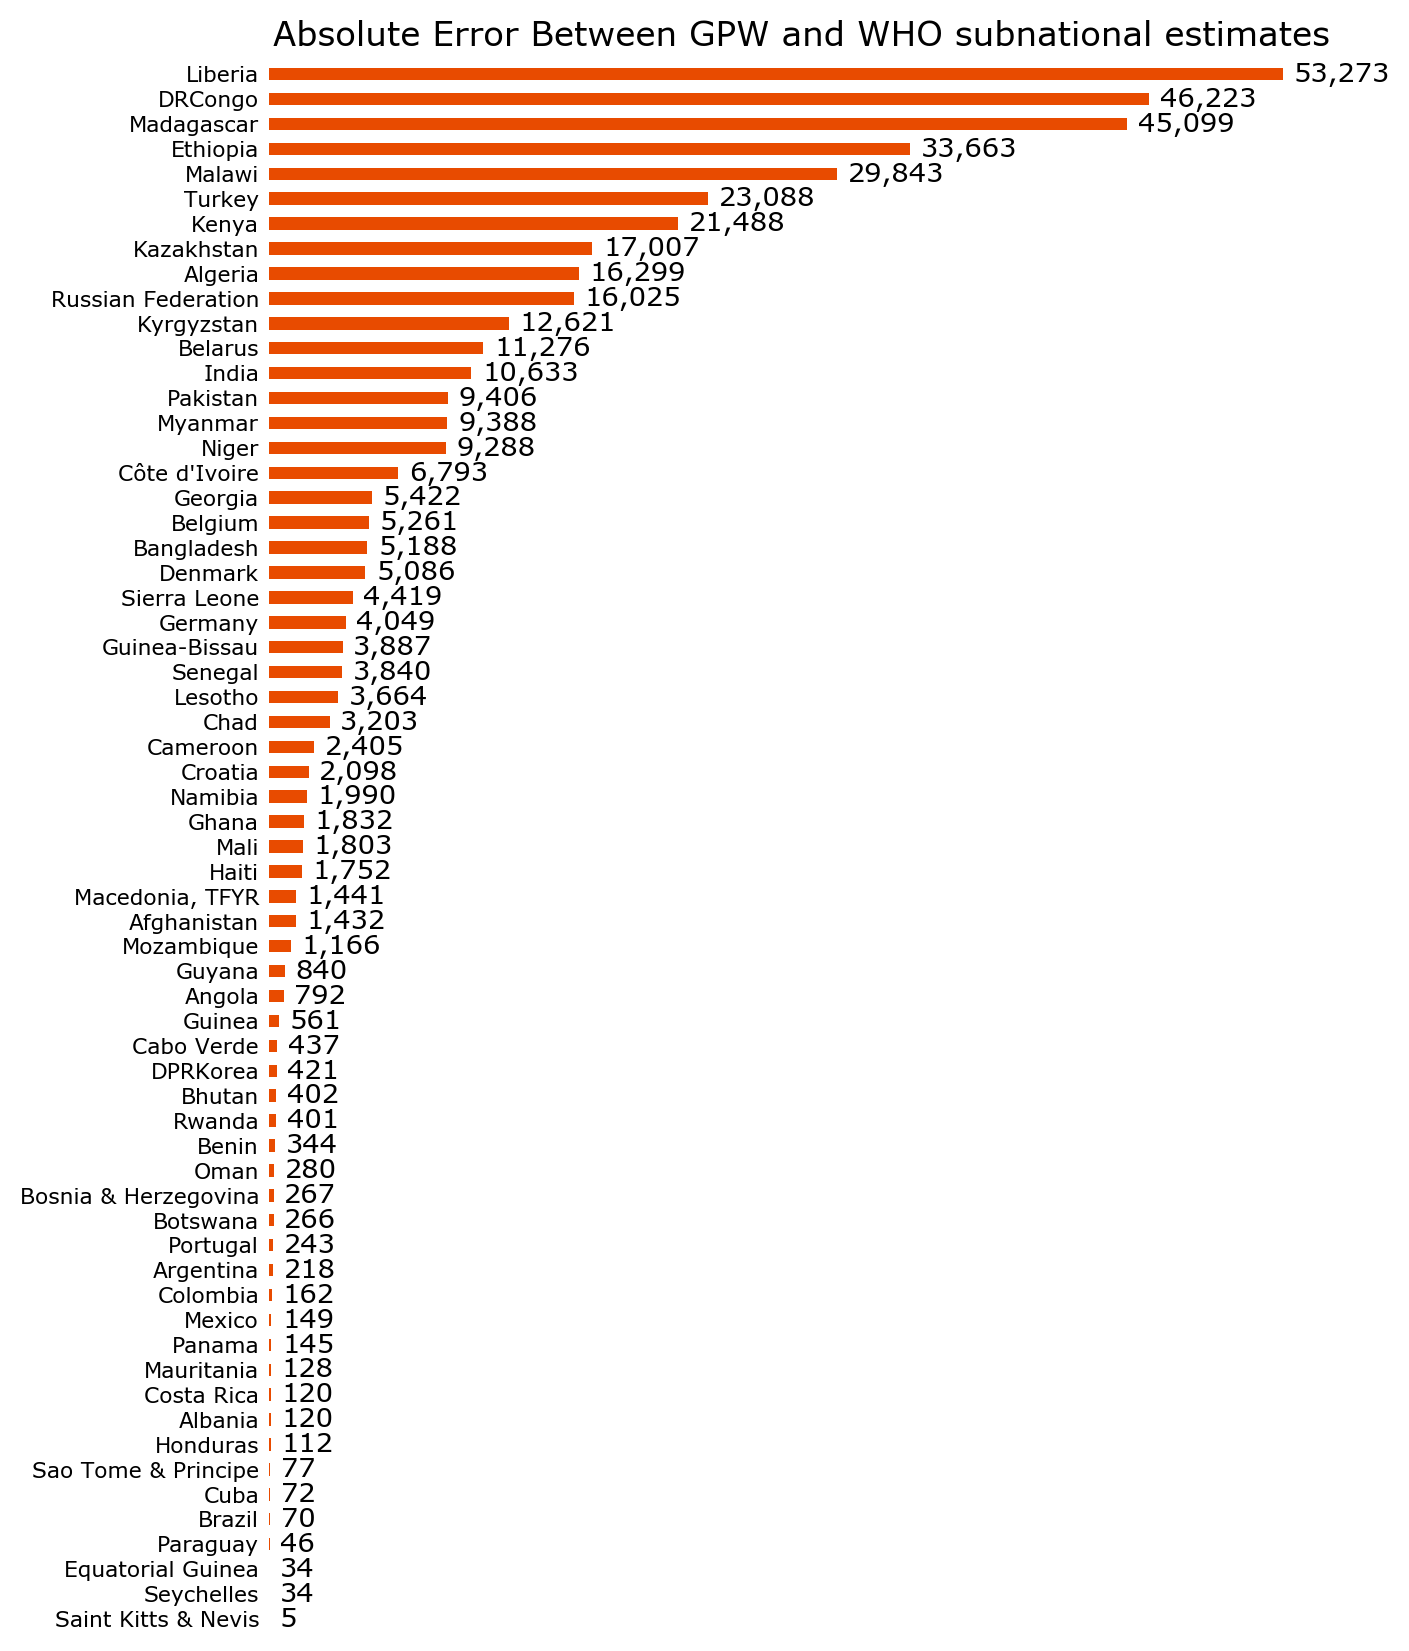

In [103]:
to_plot = (nasa_places_and_estimates.join(who_places_and_estimates, how='inner')
                                    .assign(pct_diff1=lambda x: np.abs(x[1.0] - x.est_denom_1) / x.est_denom_1)
                                    .assign(pct_diff2=lambda x: np.abs(x[2.0] - x.est_denom_2) / x.est_denom_2)
                                    .assign(pct_diff=lambda x: np.where(pd.notnull(x.pct_diff1), x.pct_diff1, x.pct_diff2))
                                    .assign(diff1=lambda x: np.abs(x[1.0] - x.est_denom_1))
                                    .assign(diff2=lambda x: np.abs(x[2.0] - x.est_denom_2))
                                    .assign(diff=lambda x: np.where(pd.notnull(x.diff1), x.diff1, x.diff2))
                                    .replace({np.inf: np.nan})
                                    .dropna(subset=['diff'])
                                    .groupby('ISOALPHA')
                                    .diff
                                    .mean()
                                    .sort_values(ascending=False))

to_plot.rename(index=code_to_name, inplace=True)

PLOT_LIM = 64
FS=10

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=comma_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.head(PLOT_LIM).sort_values(),
                font_size=FS,
                horizontal=True,
                label_formatter=comma_func_formatter(),
                color=PALETTE['orange']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Absolute Error Between GPW and WHO subnational estimates'.format(PLOT_LIM))

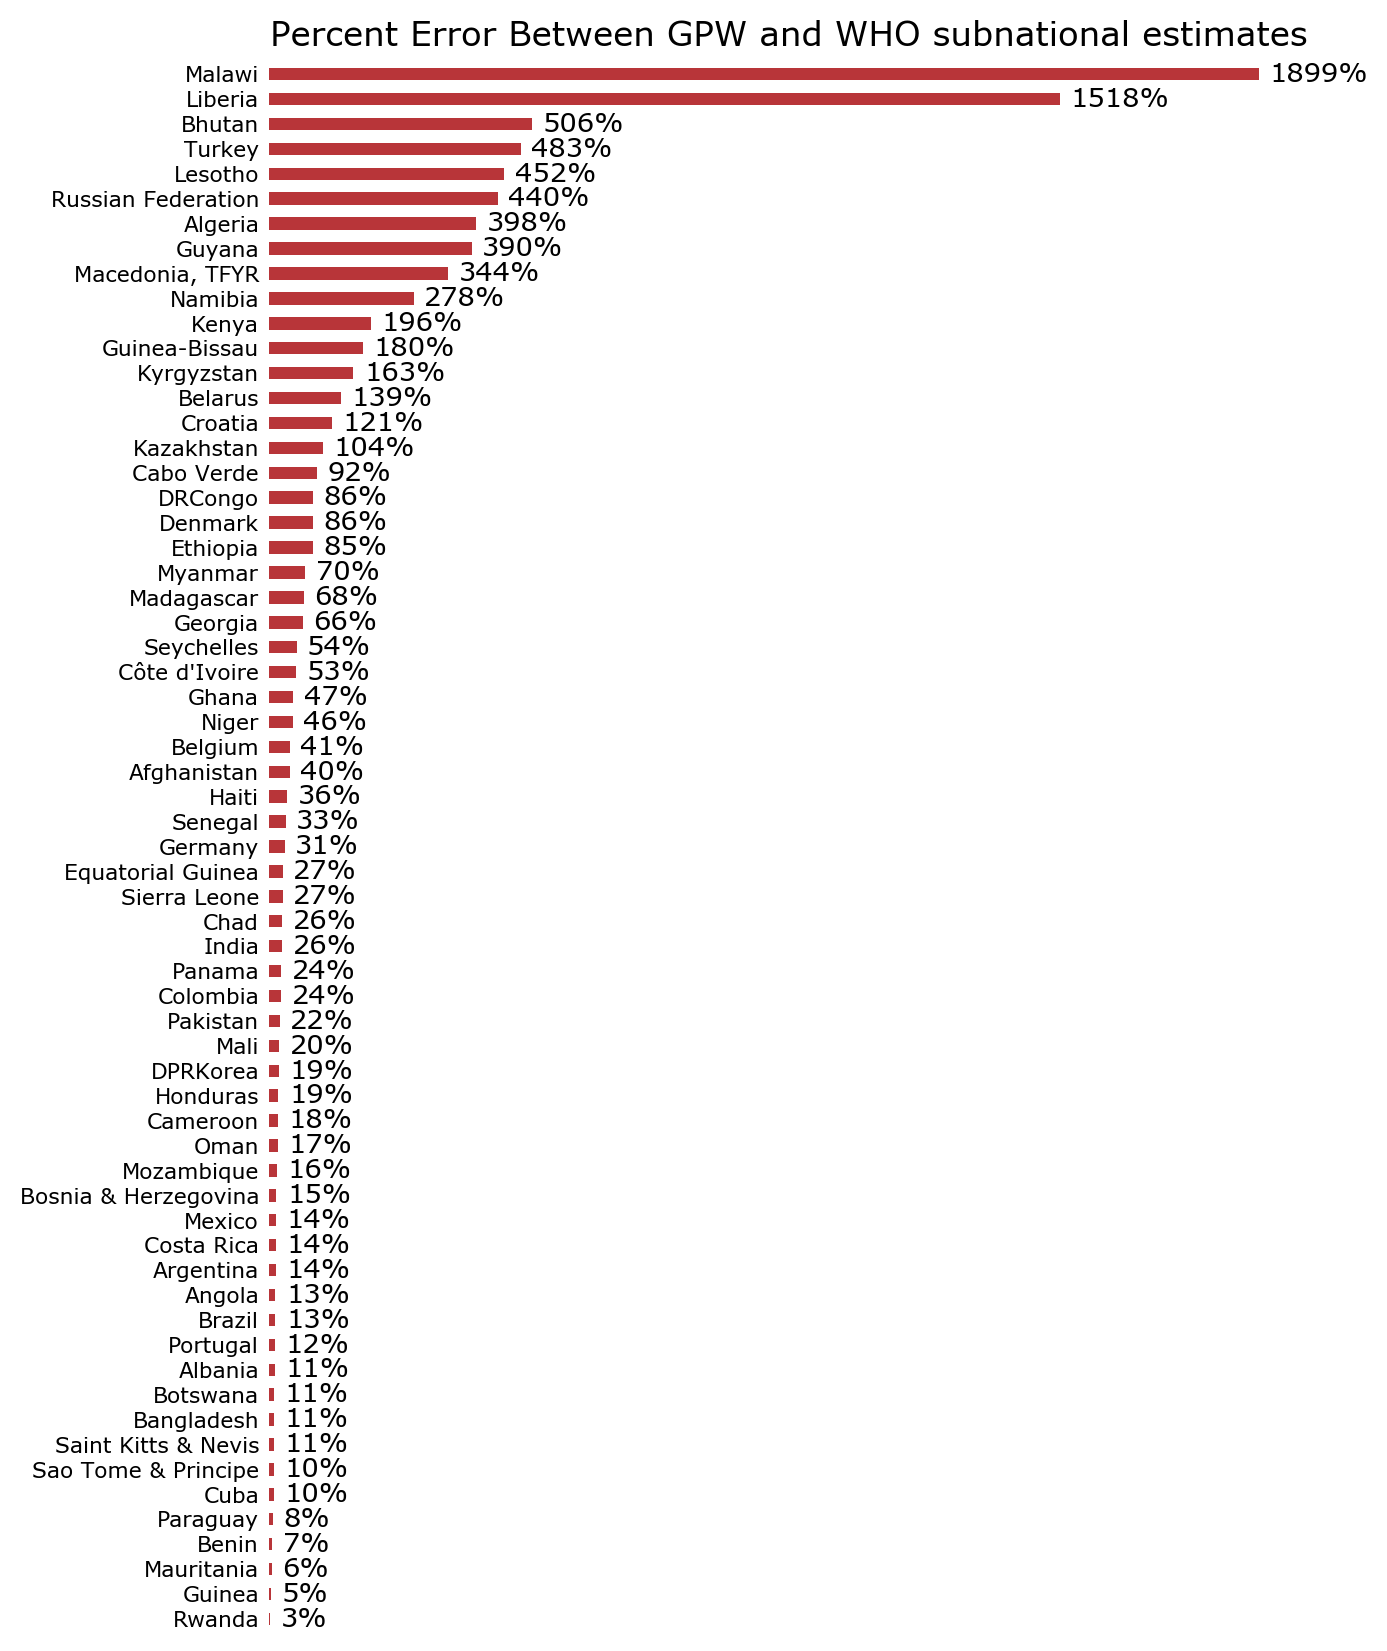

In [110]:
to_plot = (nasa_places_and_estimates.join(who_places_and_estimates, how='inner')
                                    .assign(diff1=lambda x: np.abs(x[1.0] - x.est_denom_1))
                                    .assign(diff2=lambda x: np.abs(x[2.0] - x.est_denom_2))
                                    .assign(abs_diff=lambda x: np.where(pd.notnull(x.diff1), x.diff1, x.diff2))
                                    .assign(total_denom=lambda x: np.where(pd.notnull(x.est_denom_1), x.est_denom_1, x.est_denom_2))
                                    .replace({np.inf: np.nan})
                                    .dropna(subset=['abs_diff', 'total_denom'])
                                    .groupby('ISOALPHA')
                                    .apply(lambda x: x.abs_diff.sum() / x.total_denom.sum())
                                    .sort_values(ascending=False))

to_plot

to_plot.rename(index=code_to_name, inplace=True)

PLOT_LIM = 64
FS=10

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.head(PLOT_LIM).sort_values(),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['red']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Percent Error Between GPW and WHO subnational estimates'.format(PLOT_LIM))

In [107]:
dr_check = (nasa_places_and_estimates.join(who_places_and_estimates, how='inner')
                                    .assign(pct_diff1=lambda x: np.abs(x[1.0] - x.est_denom_1) / x.est_denom_1)
                                    .assign(pct_diff2=lambda x: np.abs(x[2.0] - x.est_denom_2) / x.est_denom_2)
                                    .assign(pct_diff=lambda x: np.where(pd.notnull(x.pct_diff1), x.pct_diff1, x.pct_diff2))
                                    .assign(diff1=lambda x: np.abs(x[1.0] - x.est_denom_1))
                                    .assign(diff2=lambda x: np.abs(x[2.0] - x.est_denom_2))
                                    .assign(diff=lambda x: np.where(pd.notnull(x.diff1), x.diff1, x.diff2))
                                    .replace({np.inf: np.nan}))

dr_check[dr_check.ISOALPHA == 'RWA']

,est_denom_1,est_denom_2,ISOALPHA,1.0,2.0,5.0,pct_diff1,pct_diff2,pct_diff,diff1,diff2,diff
place_id,,,,,,,,,,,,
ChIJ3VeFQKM92xkRGShPWLGGEeM,12894.276974,12517.764086,RWA,11609.0,NaN,NaN,0.099678,NaN,0.099678,1285.276974,NaN,1285.276974
ChIJ4W4sOJes3BkRc130eTg1hRU,12818.848796,12444.538411,RWA,12209.0,NaN,NaN,0.047574,NaN,0.047574,609.848796,NaN,609.848796
ChIJ6zkglUvbxBkRPS7hjMrLxXE,12318.855016,11959.144450,RWA,11482.0,NaN,NaN,0.067933,NaN,0.067933,836.855016,NaN,836.855016
ChIJ7a6DN8sp3RkRut8FfonqN1k,11095.729736,10771.734428,RWA,10952.0,NaN,NaN,0.012954,NaN,0.012954,143.729736,NaN,143.729736
ChIJI-ovrdE-wxkRr3ixntkl0Rk,11623.250192,11283.851286,RWA,10920.0,NaN,NaN,0.060504,NaN,0.060504,703.250192,NaN,703.250192
ChIJLQCf9FOMwhkRcnXLFhMwcX0,13664.992116,13265.974346,RWA,13523.0,NaN,NaN,0.010391,NaN,0.010391,141.992116,NaN,141.992116
ChIJLbX9B0-swxkRdmp2h4hwYDA,10203.115284,9905.184318,RWA,9929.0,NaN,NaN,0.026866,NaN,0.026866,274.115284,NaN,274.115284
ChIJY9QCMp7z3BkR6SMq6nizzh4,11022.049788,10700.205934,RWA,11410.0,NaN,NaN,0.035198,NaN,0.035198,387.950212,NaN,387.950212
ChIJa5tJz5NW3BkRfGcTtmHdUPs,9748.321196,9463.670217,RWA,9942.0,NaN,NaN,0.019868,NaN,0.019868,193.678804,NaN,193.678804


In [112]:
test = (nasa_places_and_estimates.join(who_places_and_estimates, how='inner'))
test[pd.notnull(test[5.0])].ISOALPHA.value_counts()        


MEX    1212
ARG     215
CUB      51
DOM       2
Name: ISOALPHA, dtype: int64